loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50, Train Loss: 0.8490, Val Loss: 0.3637
Epoch 2/50, Train Loss: 0.3292, Val Loss: 0.2856
Epoch 3/50, Train Loss: 0.2395, Val Loss: 0.1880
Epoch 4/50, Train Loss: 0.1967, Val Loss: 0.1845
Epoch 5/50, Train Loss: 0.1876, Val Loss: 0.1868
Epoch 6/50, Train Loss: 0.1842, Val Loss: 0.1796
Epoch 7/50, Train Loss: 0.1769, Val Loss: 0.1687
Epoch 8/50, Train Loss: 0.1612, Val Loss: 0.1799
Epoch 9/50, Train Loss: 0.1572, Val Loss: 0.1635
Epoch 10/50, Train Loss: 0.1503, Val Loss: 0.1653
Epoch 11/50, Train Loss: 0.1506, Val Loss: 0.1862
Epoch 12/50, Train Loss: 0.1449, Val Loss: 0.1733
Epoch 13/50, Train Loss: 0.1452, Val Loss: 0.1562
Epoch 14/50, Train Loss: 0.1359, Val Loss: 0.1671
Epoch 15/50, Train Loss: 0.1441, Val Loss: 0.1656
Epoch 16/50, Train Loss: 0.1440, Val Loss: 0.1559
Epoch 17/50, Train Loss: 0.1375, Val Loss: 0.1370
Epoch 18/50, Train Loss: 0.1253, Val Loss: 0.1381
Epoch 19/50, Train Loss: 0.1316, Val Loss: 0.1493
Epoch 20/50, Train Loss: 0.1410, Val Loss: 0.1517
Epoch 21/

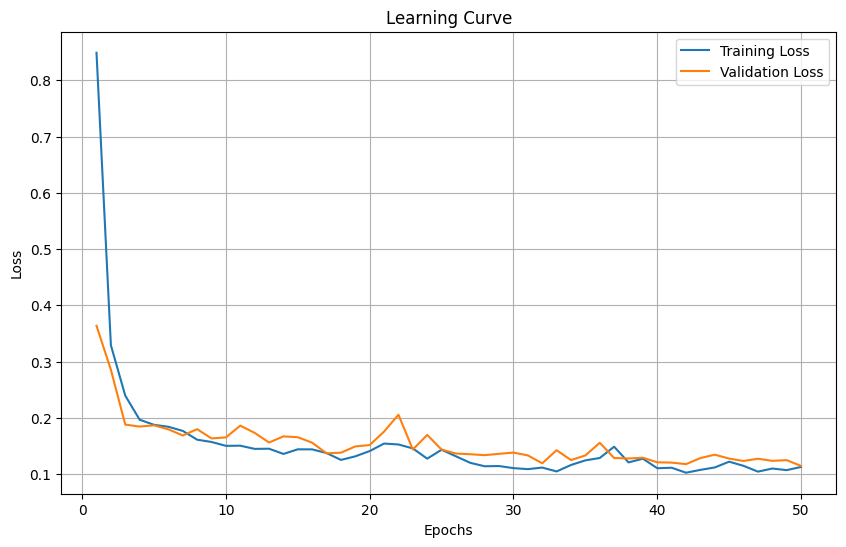

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Precision: 0.8280
Recall: 0.8497
Average IoU: 0.9614
12


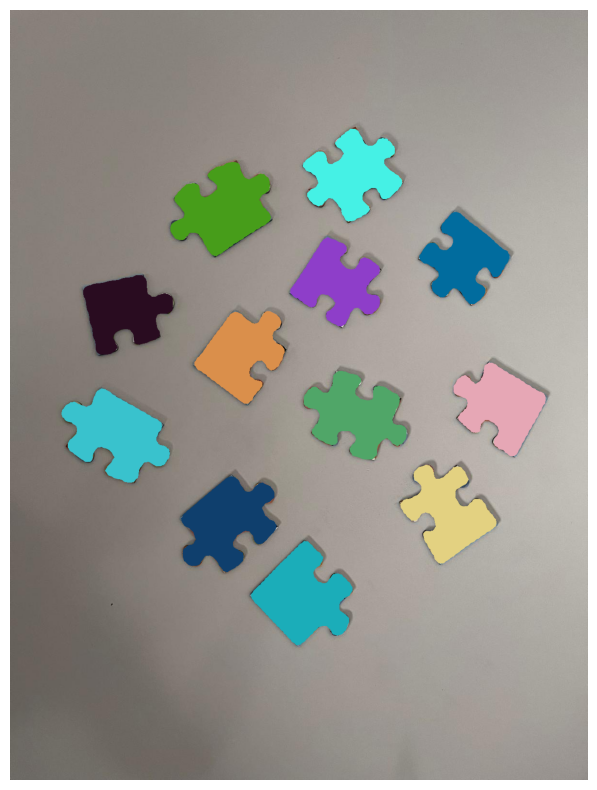

In [ ]:
import torch
from torch.utils.data.dataloader import default_collate
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from pycocotools.coco import COCO
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from collections import defaultdict

# custom collate function needed to handle images of different sizes
def custom_collate(batch):
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]

    # Adding padding to ensure images are the same size
    max_size = tuple(max(s) for s in zip(*[img.shape for img in images]))
    padded_images = []
    for img in images:
        padding = [max_size[i] - img.shape[i] for i in range(len(img.shape))]
        padded_img = torch.nn.functional.pad(img, (0, padding[2], 0, padding[1], 0, padding[0]))
        padded_images.append(padded_img)

    images = torch.stack(padded_images)

    return images, targets

class HastyDataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation_file, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation_file)
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __getitem__(self, index):
        # Loading image
        img_id = self.ids[index]
        img_info = self.coco.loadImgs(img_id)[0]
        image = Image.open(os.path.join(self.root, img_info['file_name'])).convert("RGB")

        # Loading  annotations
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        # handling bounding boxes and masks
        num_objs = len(anns)
        boxes = []
        masks = []
        labels = []

        for i in range(num_objs):
            xmin = anns[i]['bbox'][0]
            ymin = anns[i]['bbox'][1]
            xmax = xmin + anns[i]['bbox'][2]
            ymax = ymin + anns[i]['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])
            masks.append(self.coco.annToMask(anns[i]))
            labels.append(anns[i]['category_id'])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(np.array(masks), dtype=torch.uint8)

        image_id = torch.tensor([img_id])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            image = self.transforms(image)

        return image, target

    def __len__(self):
        return len(self.ids)

def get_transform():
    transforms = []
    transforms.append(T.ToTensor())
    return T.Compose(transforms)

# Dataset loaders

dataset = HastyDataset(root='/content/drive/MyDrive/torch_model/dataset/train',
                             annotation_file='/content/drive/MyDrive/torch_model/train_annotations.json',
                             transforms=get_transform())

data_loader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=4,
                         collate_fn=custom_collate)


val_dataset = HastyDataset(root='/content/drive/MyDrive/torch_model/dataset/val',
                           annotation_file='/content/drive/MyDrive/torch_model/val_annotations.json',
                           transforms=get_transform())

val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=2,
                        collate_fn=custom_collate)



# loading model
model = maskrcnn_resnet50_fpn(pretrained=True)
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0005)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

train_losses = []
val_losses = []

# training loop
num_epochs = 50
best_val_loss = float('inf')
patience = 10
no_improve_epochs = 0

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for images, targets in data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_train_loss += losses.item()

    avg_train_loss = total_train_loss / len(data_loader)
    train_losses.append(avg_train_loss)


    # val loop, leaving the model in train mode but not updating weights so losses are in dict format
    model.train()
    total_val_loss = 0
    with torch.no_grad():
        for images, targets in val_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            total_val_loss += losses.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        no_improve_epochs = 0
        torch.save(model.state_dict(), 'best_mask_rcnn_model.pth')
    else:
        no_improve_epochs += 1

    if no_improve_epochs >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

torch.save(model.state_dict(), 'mask_rcnn_model.pth')

def plot_learning_curve(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Learning Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_learning_curve(train_losses, val_losses)

# Evaluate model
def calculate_iou(pred_mask, true_mask):
    intersection = np.logical_and(pred_mask, true_mask)
    union = np.logical_or(pred_mask, true_mask)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def calculate_ap(recalls, precisions):
    indices = np.argsort(recalls)
    recalls = recalls[indices]
    precisions = precisions[indices]

    precisions = np.concatenate([[0], precisions, [0]])
    recalls = np.concatenate([[0], recalls, [1]])

    for i in range(precisions.shape[0] - 2, -1, -1):
        precisions[i] = np.maximum(precisions[i], precisions[i + 1])

    indices = np.where(recalls[1:] != recalls[:-1])[0]
    ap = np.sum((recalls[indices + 1] - recalls[indices]) * precisions[indices + 1])
    return ap

def evaluate_model(model, data_loader, device, iou_threshold=0.95):
    model.eval()
    TP = 0
    FP = 0
    FN = 0
    ious = []
    all_predictions = defaultdict(list)
    all_targets = defaultdict(list)

    with torch.no_grad():
        for images, targets in data_loader:
            images = [img.to(device) for img in images]
            predictions = model(images)

            for prediction, target in zip(predictions, targets):
                pred_masks = (prediction['masks'] > 0.5).squeeze(1).cpu().numpy()
                pred_scores = prediction['scores'].cpu().numpy()
                true_masks = target['masks'].cpu().numpy()

                used_gt = []
                for pred_mask, pred_score in zip(pred_masks, pred_scores):
                    match_found = False
                    for idx, true_mask in enumerate(true_masks):
                        if idx in used_gt:
                            continue
                        iou = calculate_iou(pred_mask, true_mask)
                        if iou >= iou_threshold:
                            TP += 1
                            match_found = True
                            used_gt.append(idx)
                            ious.append(iou)
                            all_predictions[iou_threshold].append((pred_score, 1))
                            break
                    if not match_found:
                        FP += 1
                        all_predictions[iou_threshold].append((pred_score, 0))

                FN += len(true_masks) - len(used_gt)
                all_targets[iou_threshold].extend([1] * len(true_masks))

    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN) if TP + FN > 0 else 0
    average_iou = sum(ious) / len(ious) if ious else 0

    return precision, recall, average_iou



test_dataset = HastyDataset(root= '/content/drive/MyDrive/torch_model/dataset/Test',
                            annotation_file='/content/drive/MyDrive/torch_model/test_annotations.json',
                            transforms=get_transform())

test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=2,
                         collate_fn=custom_collate)



precision, recall, average_iou = evaluate_model(model, test_loader, device)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Average IoU: {average_iou:.4f}")




def visualise_masks(image, prediction, threshold=0.5):
    if isinstance(image, torch.Tensor):
        image = T.ToPILImage()(image)

    image = image.convert("RGBA")
    img_np = np.array(image)
    result = Image.new('RGBA', image.size)
    result_np = np.array(result)

    masks = prediction['masks'] > threshold
    print(len(masks))

    for i in range(len(masks)):
        if masks[i].any():
            red, green, blue = np.random.randint(0, 255, 3)
            mask = masks[i, 0].cpu().numpy()
            result_np[mask] = [red, green, blue, 255]

    blended_img_np = np.where(result_np[:, :, 3:4] > 0, result_np, img_np)

    result_image = Image.fromarray(blended_img_np)

    plt.figure(figsize=(10, 10))
    plt.imshow(result_image)
    plt.axis('off')
    plt.show()

model.eval()
image, _ = val_dataset[0]

with torch.no_grad():
    prediction = model([image.to(device)])[0]

visualise_masks(image, prediction)

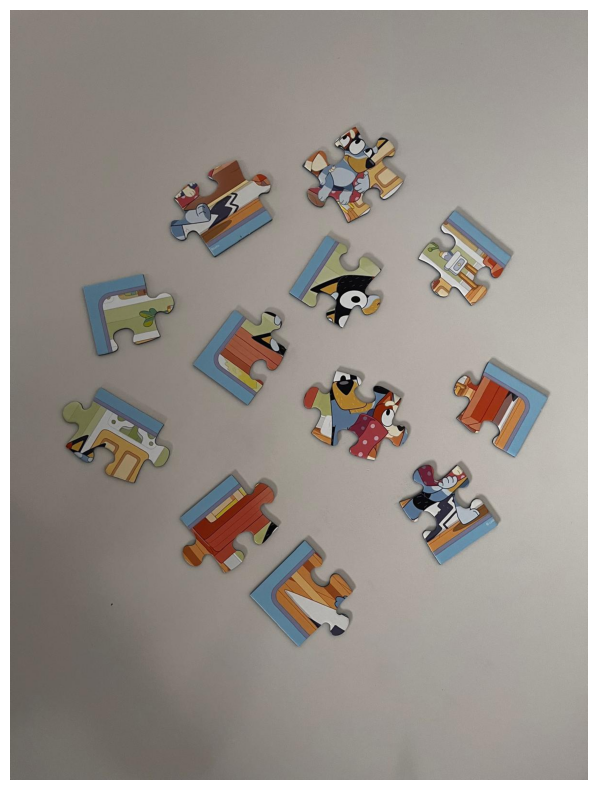

In [ ]:
image, _ = val_dataset[0]


if isinstance(image, torch.Tensor):
    image = T.ToPILImage()(image)

image = image.convert("RGBA")
img_np = np.array(image)
result = Image.new('RGBA', image.size)
result_np = np.array(result)
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.show()

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Epoch 1/50, Train Loss: 1.1199, Val Loss: 0.6511
Epoch 2/50, Train Loss: 0.6434, Val Loss: 0.5134
Epoch 3/50, Train Loss: 0.5213, Val Loss: 0.4489
Epoch 4/50, Train Loss: 0.4606, Val Loss: 0.4441
Epoch 5/50, Train Loss: 0.4346, Val Loss: 0.3771
Epoch 6/50, Train Loss: 0.3888, Val Loss: 0.3701
Epoch 7/50, Train Loss: 0.3832, Val Loss: 0.3810
Epoch 8/50, Train Loss: 0.3515, Val Loss: 0.3405
Epoch 9/50, Train Loss: 0.3408, Val Loss: 0.3454
Epoch 10/50, Train Loss: 0.3239, Val Loss: 0.3449
Epoch 11/50, Train Loss: 0.3147, Val Loss: 0.3359
Epoch 12/50, Train Loss: 0.2908, Val Loss: 0.3198
Epoch 13/50, Train Loss: 0.2827, Val Loss: 0.3244
Epoch 14/50, Train Loss: 0.2875, Val Loss: 0.3094
Epoch 15/50, Train Loss: 0.2685, Val Loss: 0.3123
Epoch 16/50, Train Loss: 0.2654, Val Loss: 0.2986
Epoch 17/50, Train Loss: 0.2580, Val Loss: 

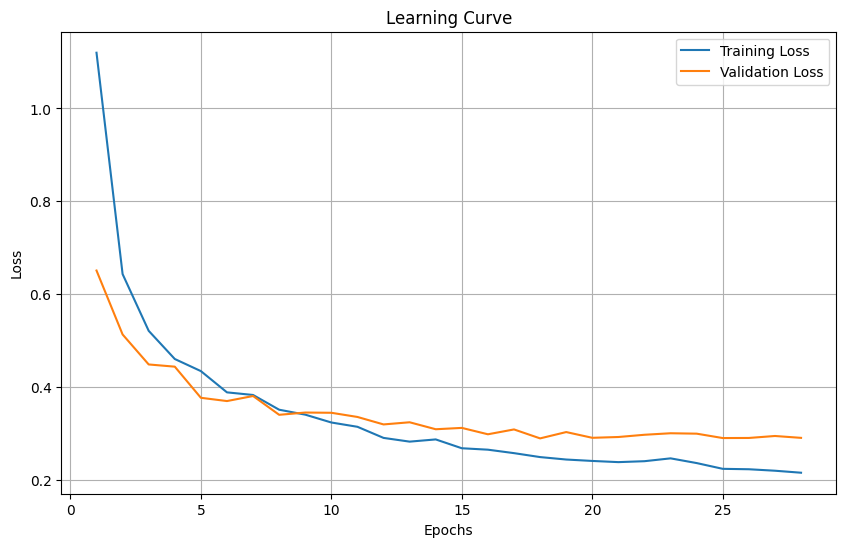

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Precision: 0.1919
Recall: 0.2157
Average IoU: 0.9580
13


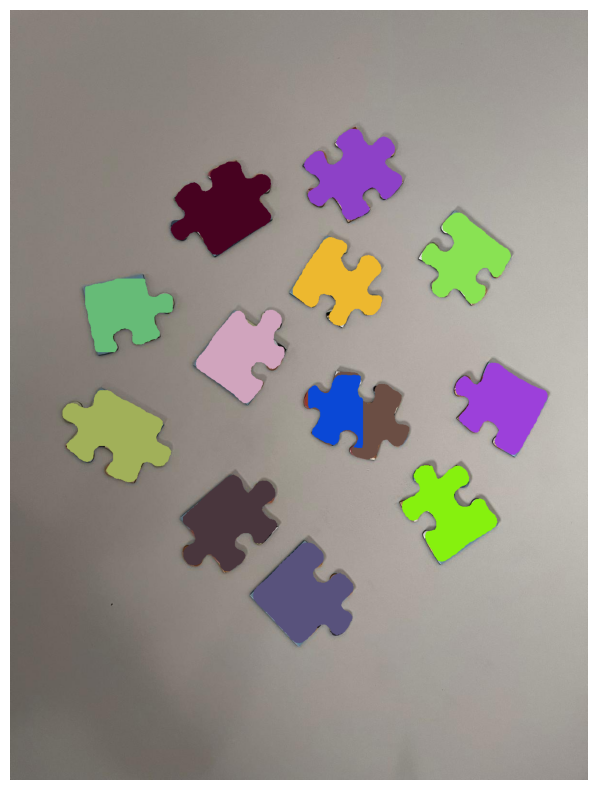

In [ ]:
import torch
from torch.utils.data.dataloader import default_collate
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from pycocotools.coco import COCO
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from collections import defaultdict

# custom collate function needed to handle images of different sizes
def custom_collate(batch):
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]

    # Adding padding to ensure images are the same size
    max_size = tuple(max(s) for s in zip(*[img.shape for img in images]))
    padded_images = []
    for img in images:
        padding = [max_size[i] - img.shape[i] for i in range(len(img.shape))]
        padded_img = torch.nn.functional.pad(img, (0, padding[2], 0, padding[1], 0, padding[0]))
        padded_images.append(padded_img)

    images = torch.stack(padded_images)

    return images, targets

class HastyDataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation_file, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation_file)
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __getitem__(self, index):
        # Loading image
        img_id = self.ids[index]
        img_info = self.coco.loadImgs(img_id)[0]
        image = Image.open(os.path.join(self.root, img_info['file_name'])).convert("RGB")

        # Loading  annotations
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        # handling bounding boxes and masks
        num_objs = len(anns)
        boxes = []
        masks = []
        labels = []

        for i in range(num_objs):
            xmin = anns[i]['bbox'][0]
            ymin = anns[i]['bbox'][1]
            xmax = xmin + anns[i]['bbox'][2]
            ymax = ymin + anns[i]['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])
            masks.append(self.coco.annToMask(anns[i]))
            labels.append(anns[i]['category_id'])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(np.array(masks), dtype=torch.uint8)

        image_id = torch.tensor([img_id])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            image = self.transforms(image)

        return image, target

    def __len__(self):
        return len(self.ids)

def get_transform():
    transforms = []
    transforms.append(T.ToTensor())
    return T.Compose(transforms)

# Dataset loaders

dataset = HastyDataset(root='/content/drive/MyDrive/torch_model/dataset/train',
                             annotation_file='/content/drive/MyDrive/torch_model/train_annotations.json',
                             transforms=get_transform())

data_loader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=4,
                         collate_fn=custom_collate)


val_dataset = HastyDataset(root='/content/drive/MyDrive/torch_model/dataset/val',
                           annotation_file='/content/drive/MyDrive/torch_model/val_annotations.json',
                           transforms=get_transform())

val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=2,
                        collate_fn=custom_collate)



# loading model
model = maskrcnn_resnet50_fpn(pretrained=True)
for param in model.backbone.parameters():
    param.requires_grad = False
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0005)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

train_losses = []
val_losses = []

# training loop
num_epochs = 50
best_val_loss = float('inf')
patience = 10
no_improve_epochs = 0

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for images, targets in data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_train_loss += losses.item()

    avg_train_loss = total_train_loss / len(data_loader)
    train_losses.append(avg_train_loss)


    # val loop, leaving the model in train mode but not updating weights so losses are in dict format
    model.train()
    total_val_loss = 0
    with torch.no_grad():
        for images, targets in val_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            total_val_loss += losses.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        no_improve_epochs = 0
        torch.save(model.state_dict(), 'best_mask_rcnn_model.pth')
    else:
        no_improve_epochs += 1

    if no_improve_epochs >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

torch.save(model.state_dict(), 'mask_rcnn_model.pth')

def plot_learning_curve(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Learning Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_learning_curve(train_losses, val_losses)

# Evaluate model
def calculate_iou(pred_mask, true_mask):
    intersection = np.logical_and(pred_mask, true_mask)
    union = np.logical_or(pred_mask, true_mask)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def calculate_ap(recalls, precisions):
    indices = np.argsort(recalls)
    recalls = recalls[indices]
    precisions = precisions[indices]

    precisions = np.concatenate([[0], precisions, [0]])
    recalls = np.concatenate([[0], recalls, [1]])

    for i in range(precisions.shape[0] - 2, -1, -1):
        precisions[i] = np.maximum(precisions[i], precisions[i + 1])

    indices = np.where(recalls[1:] != recalls[:-1])[0]
    ap = np.sum((recalls[indices + 1] - recalls[indices]) * precisions[indices + 1])
    return ap

def evaluate_model(model, data_loader, device, iou_threshold=0.95):
    model.eval()
    TP = 0
    FP = 0
    FN = 0
    ious = []
    all_predictions = defaultdict(list)
    all_targets = defaultdict(list)

    with torch.no_grad():
        for images, targets in data_loader:
            images = [img.to(device) for img in images]
            predictions = model(images)

            for prediction, target in zip(predictions, targets):
                pred_masks = (prediction['masks'] > 0.5).squeeze(1).cpu().numpy()
                pred_scores = prediction['scores'].cpu().numpy()
                true_masks = target['masks'].cpu().numpy()

                used_gt = []
                for pred_mask, pred_score in zip(pred_masks, pred_scores):
                    match_found = False
                    for idx, true_mask in enumerate(true_masks):
                        if idx in used_gt:
                            continue
                        iou = calculate_iou(pred_mask, true_mask)
                        if iou >= iou_threshold:
                            TP += 1
                            match_found = True
                            used_gt.append(idx)
                            ious.append(iou)
                            all_predictions[iou_threshold].append((pred_score, 1))
                            break
                    if not match_found:
                        FP += 1
                        all_predictions[iou_threshold].append((pred_score, 0))

                FN += len(true_masks) - len(used_gt)
                all_targets[iou_threshold].extend([1] * len(true_masks))

    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN) if TP + FN > 0 else 0
    average_iou = sum(ious) / len(ious) if ious else 0

    return precision, recall, average_iou



test_dataset = HastyDataset(root= '/content/drive/MyDrive/torch_model/dataset/Test',
                            annotation_file='/content/drive/MyDrive/torch_model/test_annotations.json',
                            transforms=get_transform())

test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=2,
                         collate_fn=custom_collate)



precision, recall, average_iou = evaluate_model(model, test_loader, device)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Average IoU: {average_iou:.4f}")




def visualise_masks(image, prediction, threshold=0.5):
    if isinstance(image, torch.Tensor):
        image = T.ToPILImage()(image)

    image = image.convert("RGBA")
    img_np = np.array(image)
    result = Image.new('RGBA', image.size)
    result_np = np.array(result)

    masks = prediction['masks'] > threshold
    print(len(masks))

    for i in range(len(masks)):
        if masks[i].any():
            red, green, blue = np.random.randint(0, 255, 3)
            mask = masks[i, 0].cpu().numpy()
            result_np[mask] = [red, green, blue, 255]

    blended_img_np = np.where(result_np[:, :, 3:4] > 0, result_np, img_np)

    result_image = Image.fromarray(blended_img_np)

    plt.figure(figsize=(10, 10))
    plt.imshow(result_image)
    plt.axis('off')
    plt.show()

model.eval()
image, _ = val_dataset[0]

with torch.no_grad():
    prediction = model([image.to(device)])[0]

visualise_masks(image, prediction)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Epoch 1/50, Train Loss: 1.3287, Val Loss: 0.5527
Epoch 2/50, Train Loss: 0.4626, Val Loss: 0.3639
Epoch 3/50, Train Loss: 0.3276, Val Loss: 0.2656
Epoch 4/50, Train Loss: 0.2662, Val Loss: 0.2436
Epoch 5/50, Train Loss: 0.2482, Val Loss: 0.2295
Epoch 6/50, Train Loss: 0.2327, Val Loss: 0.2293
Epoch 7/50, Train Loss: 0.2207, Val Loss: 0.2135
Epoch 8/50, Train Loss: 0.2099, Val Loss: 0.2101
Epoch 9/50, Train Loss: 0.2000, Val Loss: 0.2075
Epoch 10/50, Train Loss: 0.1958, Val Loss: 0.2045
Epoch 11/50, Train Loss: 0.1849, Val Loss: 0.1881
Epoch 12/50, Train Loss: 0.1793, Val Loss: 0.1972
Epoch 13/50, Train Loss: 0.1784, Val Loss: 0.1789
Epoch 14/50, Train Loss: 0.1725, Val Loss: 0.1810
Epoch 15/50, Train Loss: 0.1695, Val Loss: 0.1736
Epoch 16/50, Train Loss: 0.1712, Val Loss: 0.1805
Epoch 17/50, Train Loss: 0.1664, Val Loss: 

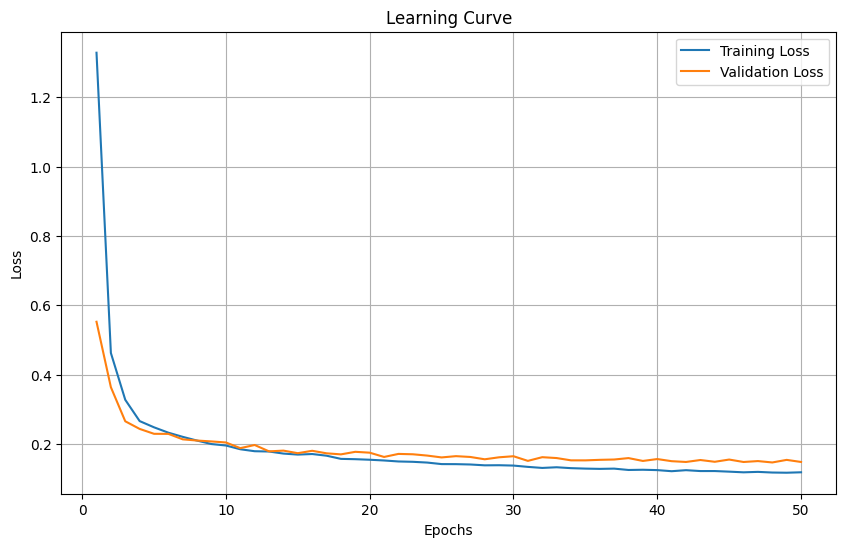

loading annotations into memory...
Done (t=0.44s)
creating index...
index created!
Precision: 0.4750
Recall: 0.4967
Average IoU: 0.9564
12


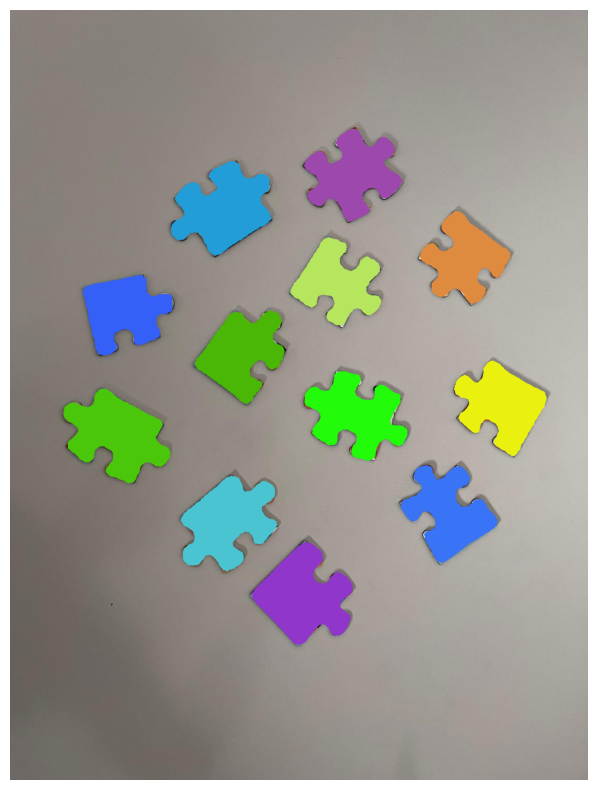

In [ ]:
import torch
from torch.utils.data.dataloader import default_collate
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from pycocotools.coco import COCO
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from collections import defaultdict

# custom collate function needed to handle images of different sizes
def custom_collate(batch):
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]

    # Adding padding to ensure images are the same size
    max_size = tuple(max(s) for s in zip(*[img.shape for img in images]))
    padded_images = []
    for img in images:
        padding = [max_size[i] - img.shape[i] for i in range(len(img.shape))]
        padded_img = torch.nn.functional.pad(img, (0, padding[2], 0, padding[1], 0, padding[0]))
        padded_images.append(padded_img)

    images = torch.stack(padded_images)

    return images, targets

class HastyDataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation_file, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation_file)
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __getitem__(self, index):
        # Loading image
        img_id = self.ids[index]
        img_info = self.coco.loadImgs(img_id)[0]
        image = Image.open(os.path.join(self.root, img_info['file_name'])).convert("RGB")

        # Loading  annotations
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        # handling bounding boxes and masks
        num_objs = len(anns)
        boxes = []
        masks = []
        labels = []

        for i in range(num_objs):
            xmin = anns[i]['bbox'][0]
            ymin = anns[i]['bbox'][1]
            xmax = xmin + anns[i]['bbox'][2]
            ymax = ymin + anns[i]['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])
            masks.append(self.coco.annToMask(anns[i]))
            labels.append(anns[i]['category_id'])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(np.array(masks), dtype=torch.uint8)

        image_id = torch.tensor([img_id])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            image = self.transforms(image)

        return image, target

    def __len__(self):
        return len(self.ids)

def get_transform():
    transforms = []
    transforms.append(T.ToTensor())
    return T.Compose(transforms)

# Dataset loaders

dataset = HastyDataset(root='/content/drive/MyDrive/torch_model/dataset/train',
                             annotation_file='/content/drive/MyDrive/torch_model/train_annotations.json',
                             transforms=get_transform())

data_loader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=4,
                         collate_fn=custom_collate)


val_dataset = HastyDataset(root='/content/drive/MyDrive/torch_model/dataset/val',
                           annotation_file='/content/drive/MyDrive/torch_model/val_annotations.json',
                           transforms=get_transform())

val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=2,
                        collate_fn=custom_collate)



# loading model
model = maskrcnn_resnet50_fpn(pretrained=True)


num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

train_losses = []
val_losses = []

# training loop
num_epochs = 50
best_val_loss = float('inf')
patience = 10
no_improve_epochs = 0

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for images, targets in data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_train_loss += losses.item()

    avg_train_loss = total_train_loss / len(data_loader)
    train_losses.append(avg_train_loss)


    # val loop, leaving the model in train mode but not updating weights so losses are in dict format
    model.train()
    total_val_loss = 0
    with torch.no_grad():
        for images, targets in val_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            total_val_loss += losses.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        no_improve_epochs = 0
        torch.save(model.state_dict(), 'best_mask_rcnn_model.pth')
    else:
        no_improve_epochs += 1

    if no_improve_epochs >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

torch.save(model.state_dict(), 'mask_rcnn_model.pth')

def plot_learning_curve(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Learning Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_learning_curve(train_losses, val_losses)

# Evaluate model
def calculate_iou(pred_mask, true_mask):
    intersection = np.logical_and(pred_mask, true_mask)
    union = np.logical_or(pred_mask, true_mask)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def calculate_ap(recalls, precisions):
    indices = np.argsort(recalls)
    recalls = recalls[indices]
    precisions = precisions[indices]

    precisions = np.concatenate([[0], precisions, [0]])
    recalls = np.concatenate([[0], recalls, [1]])

    for i in range(precisions.shape[0] - 2, -1, -1):
        precisions[i] = np.maximum(precisions[i], precisions[i + 1])

    indices = np.where(recalls[1:] != recalls[:-1])[0]
    ap = np.sum((recalls[indices + 1] - recalls[indices]) * precisions[indices + 1])
    return ap

def evaluate_model(model, data_loader, device, iou_threshold=0.95):
    model.eval()
    TP = 0
    FP = 0
    FN = 0
    ious = []
    all_predictions = defaultdict(list)
    all_targets = defaultdict(list)

    with torch.no_grad():
        for images, targets in data_loader:
            images = [img.to(device) for img in images]
            predictions = model(images)

            for prediction, target in zip(predictions, targets):
                pred_masks = (prediction['masks'] > 0.5).squeeze(1).cpu().numpy()
                pred_scores = prediction['scores'].cpu().numpy()
                true_masks = target['masks'].cpu().numpy()

                used_gt = []
                for pred_mask, pred_score in zip(pred_masks, pred_scores):
                    match_found = False
                    for idx, true_mask in enumerate(true_masks):
                        if idx in used_gt:
                            continue
                        iou = calculate_iou(pred_mask, true_mask)
                        if iou >= iou_threshold:
                            TP += 1
                            match_found = True
                            used_gt.append(idx)
                            ious.append(iou)
                            all_predictions[iou_threshold].append((pred_score, 1))
                            break
                    if not match_found:
                        FP += 1
                        all_predictions[iou_threshold].append((pred_score, 0))

                FN += len(true_masks) - len(used_gt)
                all_targets[iou_threshold].extend([1] * len(true_masks))

    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN) if TP + FN > 0 else 0
    average_iou = sum(ious) / len(ious) if ious else 0

    return precision, recall, average_iou



test_dataset = HastyDataset(root= '/content/drive/MyDrive/torch_model/dataset/Test',
                            annotation_file='/content/drive/MyDrive/torch_model/test_annotations.json',
                            transforms=get_transform())

test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=2,
                         collate_fn=custom_collate)



precision, recall, average_iou = evaluate_model(model, test_loader, device)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Average IoU: {average_iou:.4f}")




def visualise_masks(image, prediction, threshold=0.5):
    if isinstance(image, torch.Tensor):
        image = T.ToPILImage()(image)

    image = image.convert("RGBA")
    img_np = np.array(image)
    result = Image.new('RGBA', image.size)
    result_np = np.array(result)

    masks = prediction['masks'] > threshold
    print(len(masks))

    for i in range(len(masks)):
        if masks[i].any():
            red, green, blue = np.random.randint(0, 255, 3)
            mask = masks[i, 0].cpu().numpy()
            result_np[mask] = [red, green, blue, 255]

    blended_img_np = np.where(result_np[:, :, 3:4] > 0, result_np, img_np)

    result_image = Image.fromarray(blended_img_np)

    plt.figure(figsize=(10, 10))
    plt.imshow(result_image)
    plt.axis('off')
    plt.show()

model.eval()
image, _ = val_dataset[0]

with torch.no_grad():
    prediction = model([image.to(device)])[0]

visualise_masks(image, prediction)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Epoch 1/50, Train Loss: 1.3859, Val Loss: 0.8273
Epoch 2/50, Train Loss: 0.7288, Val Loss: 0.5522
Epoch 3/50, Train Loss: 0.5620, Val Loss: 0.4558
Epoch 4/50, Train Loss: 0.5023, Val Loss: 0.4572
Epoch 5/50, Train Loss: 0.4585, Val Loss: 0.4177
Epoch 6/50, Train Loss: 0.4314, Val Loss: 0.4114
Epoch 7/50, Train Loss: 0.4171, Val Loss: 0.4211
Epoch 8/50, Train Loss: 0.4128, Val Loss: 0.3771
Epoch 9/50, Train Loss: 0.3825, Val Loss: 0.3602
Epoch 10/50, Train Loss: 0.3858, Val Loss: 0.3644
Epoch 11/50, Train Loss: 0.3561, Val Loss: 0.3799
Epoch 12/50, Train Loss: 0.3517, Val Loss: 0.3713
Epoch 13/50, Train Loss: 0.3345, Val Loss: 0.3473
Epoch 14/50, Train Loss: 0.3248, Val Loss: 0.3436
Epoch 15/50, Train Loss: 0.3261, Val Loss: 0.3372
Epoch 16/50, Train Loss: 0.3071, Val Loss: 0.3504
Epoch 17/50, Train Loss: 0.3203, Val Loss: 

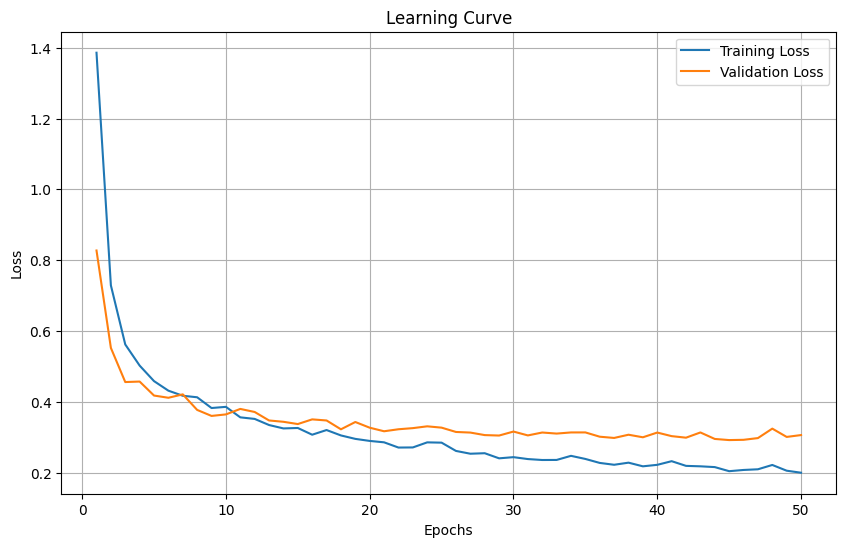

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Precision: 0.1697
Recall: 0.1830
Average IoU: 0.9577
14


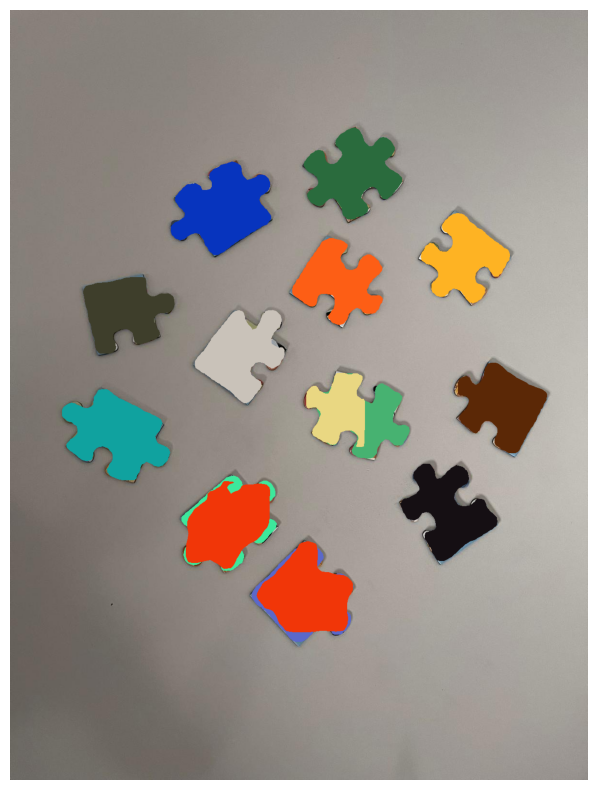

In [ ]:
import torch
from torch.utils.data.dataloader import default_collate
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from pycocotools.coco import COCO
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from collections import defaultdict

# custom collate function needed to handle images of different sizes
def custom_collate(batch):
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]

    # Adding padding to ensure images are the same size
    max_size = tuple(max(s) for s in zip(*[img.shape for img in images]))
    padded_images = []
    for img in images:
        padding = [max_size[i] - img.shape[i] for i in range(len(img.shape))]
        padded_img = torch.nn.functional.pad(img, (0, padding[2], 0, padding[1], 0, padding[0]))
        padded_images.append(padded_img)

    images = torch.stack(padded_images)

    return images, targets

class HastyDataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation_file, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation_file)
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __getitem__(self, index):
        # Loading image
        img_id = self.ids[index]
        img_info = self.coco.loadImgs(img_id)[0]
        image = Image.open(os.path.join(self.root, img_info['file_name'])).convert("RGB")

        # Loading  annotations
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        # handling bounding boxes and masks
        num_objs = len(anns)
        boxes = []
        masks = []
        labels = []

        for i in range(num_objs):
            xmin = anns[i]['bbox'][0]
            ymin = anns[i]['bbox'][1]
            xmax = xmin + anns[i]['bbox'][2]
            ymax = ymin + anns[i]['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])
            masks.append(self.coco.annToMask(anns[i]))
            labels.append(anns[i]['category_id'])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(np.array(masks), dtype=torch.uint8)

        image_id = torch.tensor([img_id])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            image = self.transforms(image)

        return image, target

    def __len__(self):
        return len(self.ids)

def get_transform():
    transforms = []
    transforms.append(T.ToTensor())
    return T.Compose(transforms)

# Dataset loaders

dataset = HastyDataset(root='/content/drive/MyDrive/torch_model/dataset/train',
                             annotation_file='/content/drive/MyDrive/torch_model/train_annotations.json',
                             transforms=get_transform())

data_loader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=4,
                         collate_fn=custom_collate)


val_dataset = HastyDataset(root='/content/drive/MyDrive/torch_model/dataset/val',
                           annotation_file='/content/drive/MyDrive/torch_model/val_annotations.json',
                           transforms=get_transform())

val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=2,
                        collate_fn=custom_collate)



# loading model
model = maskrcnn_resnet50_fpn(pretrained=True)
for param in model.backbone.parameters():
    param.requires_grad = False

num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

train_losses = []
val_losses = []

# training loop
num_epochs = 50
best_val_loss = float('inf')
patience = 10
no_improve_epochs = 0

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for images, targets in data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_train_loss += losses.item()

    avg_train_loss = total_train_loss / len(data_loader)
    train_losses.append(avg_train_loss)


    # val loop, leaving the model in train mode but not updating weights so losses are in dict format
    model.train()
    total_val_loss = 0
    with torch.no_grad():
        for images, targets in val_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            total_val_loss += losses.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        no_improve_epochs = 0
        torch.save(model.state_dict(), 'best_mask_rcnn_model.pth')
    else:
        no_improve_epochs += 1

    if no_improve_epochs >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

torch.save(model.state_dict(), 'mask_rcnn_model.pth')

def plot_learning_curve(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Learning Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_learning_curve(train_losses, val_losses)

# Evaluate model
def calculate_iou(pred_mask, true_mask):
    intersection = np.logical_and(pred_mask, true_mask)
    union = np.logical_or(pred_mask, true_mask)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def calculate_ap(recalls, precisions):
    indices = np.argsort(recalls)
    recalls = recalls[indices]
    precisions = precisions[indices]

    precisions = np.concatenate([[0], precisions, [0]])
    recalls = np.concatenate([[0], recalls, [1]])

    for i in range(precisions.shape[0] - 2, -1, -1):
        precisions[i] = np.maximum(precisions[i], precisions[i + 1])

    indices = np.where(recalls[1:] != recalls[:-1])[0]
    ap = np.sum((recalls[indices + 1] - recalls[indices]) * precisions[indices + 1])
    return ap

def evaluate_model(model, data_loader, device, iou_threshold=0.95):
    model.eval()
    TP = 0
    FP = 0
    FN = 0
    ious = []
    all_predictions = defaultdict(list)
    all_targets = defaultdict(list)

    with torch.no_grad():
        for images, targets in data_loader:
            images = [img.to(device) for img in images]
            predictions = model(images)

            for prediction, target in zip(predictions, targets):
                pred_masks = (prediction['masks'] > 0.5).squeeze(1).cpu().numpy()
                pred_scores = prediction['scores'].cpu().numpy()
                true_masks = target['masks'].cpu().numpy()

                used_gt = []
                for pred_mask, pred_score in zip(pred_masks, pred_scores):
                    match_found = False
                    for idx, true_mask in enumerate(true_masks):
                        if idx in used_gt:
                            continue
                        iou = calculate_iou(pred_mask, true_mask)
                        if iou >= iou_threshold:
                            TP += 1
                            match_found = True
                            used_gt.append(idx)
                            ious.append(iou)
                            all_predictions[iou_threshold].append((pred_score, 1))
                            break
                    if not match_found:
                        FP += 1
                        all_predictions[iou_threshold].append((pred_score, 0))

                FN += len(true_masks) - len(used_gt)
                all_targets[iou_threshold].extend([1] * len(true_masks))

    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN) if TP + FN > 0 else 0
    average_iou = sum(ious) / len(ious) if ious else 0

    return precision, recall, average_iou



test_dataset = HastyDataset(root= '/content/drive/MyDrive/torch_model/dataset/Test',
                            annotation_file='/content/drive/MyDrive/torch_model/test_annotations.json',
                            transforms=get_transform())

test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=2,
                         collate_fn=custom_collate)



precision, recall, average_iou = evaluate_model(model, test_loader, device)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Average IoU: {average_iou:.4f}")




def visualise_masks(image, prediction, threshold=0.5):
    if isinstance(image, torch.Tensor):
        image = T.ToPILImage()(image)

    image = image.convert("RGBA")
    img_np = np.array(image)
    result = Image.new('RGBA', image.size)
    result_np = np.array(result)

    masks = prediction['masks'] > threshold
    print(len(masks))

    for i in range(len(masks)):
        if masks[i].any():
            red, green, blue = np.random.randint(0, 255, 3)
            mask = masks[i, 0].cpu().numpy()
            result_np[mask] = [red, green, blue, 255]

    blended_img_np = np.where(result_np[:, :, 3:4] > 0, result_np, img_np)

    result_image = Image.fromarray(blended_img_np)

    plt.figure(figsize=(10, 10))
    plt.imshow(result_image)
    plt.axis('off')
    plt.show()

model.eval()
image, _ = val_dataset[0]

with torch.no_grad():
    prediction = model([image.to(device)])[0]

visualise_masks(image, prediction)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
